# Recitation 3: Adversarial Examples and Attacks

This recitation introduces adversarial examples, i.e., specially crafted inputs that fool machine learning models. You'll learn to generate adversarial examples using gradient-based attacks and understand their implications for ML security.

**Note**: This is a tutorial session. Your homework assignment will be provided separately in Assignment 3.


## Setup

Run the code below to set up the notebook.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import copy

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Enhanced plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Adversarial attack libraries loaded!")
print("🎯 Ready to explore the dark side of machine learning...")


Using device: cpu
✅ Adversarial attack libraries loaded!
🎯 Ready to explore the dark side of machine learning...


## Part 1: Build and Train Target Model

We'll train a fresh CNN model from scratch similar to the one we created in the previous assignment to serve as our target for adversarial attacks. 


In [2]:
# Define CNN architecture for MNIST classification
class MNISTNet(nn.Module):
    """Convolutional Neural Network for MNIST digit classification."""
    
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

print("🏗️ Training a fresh CNN model for adversarial attacks...")
print("(This ensures we have a well-trained target for meaningful attack demonstrations)")

# Load MNIST training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print("📊 Loading MNIST dataset...")
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_eval = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"✅ Dataset loaded: {len(train_dataset)} training, {len(test_dataset)} test samples")

# Initialize model, loss, and optimizer
model = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"🤖 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Quick training function
def train_model(model, train_loader, criterion, optimizer, epochs=3):
    """Train the model for a few epochs to get good performance."""
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        print(f"\n📚 Epoch {epoch+1}/{epochs}")
        
        with tqdm(train_loader, desc=f"Training") as pbar:
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device)
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                
                # Update progress bar
                if batch_idx % 50 == 0:
                    accuracy = 100. * correct / total
                    avg_loss = running_loss / (batch_idx + 1)
                    pbar.set_postfix({
                        'Loss': f'{avg_loss:.4f}', 
                        'Acc': f'{accuracy:.2f}%'
                    })
        
        # Final epoch stats
        epoch_accuracy = 100. * correct / total
        epoch_loss = running_loss / len(train_loader)
        print(f"   📈 Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Test model performance
def evaluate_model(model, test_loader):
    """Evaluate model on test set."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

# Train the model
print("🚀 Starting training...")
train_model(model, train_loader, criterion, optimizer, epochs=3)

# Evaluate performance
print("\n📊 Evaluating model performance...")
test_accuracy = evaluate_model(model, test_loader_eval)
print(f"🎯 Test Accuracy: {test_accuracy:.2f}%")

if test_accuracy > 95:
    print("✅ Excellent! Model is well-trained and ready for adversarial attacks!")
elif test_accuracy > 90:
    print("✅ Good! Model performance is sufficient for attack demonstrations!")
else:
    print("⚠️  Model accuracy is lower than expected, but will work for demonstrations.")

# Save the trained model
torch.save(model.state_dict(), 'trained_mnist_model.pth')
print("💾 Model saved as 'trained_mnist_model.pth'")

print(f"\n🎯 Fresh model trained and ready for adversarial attacks!")


🏗️ Training a fresh CNN model for adversarial attacks...
(This ensures we have a well-trained target for meaningful attack demonstrations)
📊 Loading MNIST dataset...
✅ Dataset loaded: 60000 training, 10000 test samples
🤖 Model parameters: 1,625,866
🚀 Starting training...

📚 Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████| 469/469 [00:53<00:00,  8.80it/s, Loss=0.2422, Acc=92.57%]


   📈 Epoch 1 - Loss: 0.2370, Accuracy: 92.72%

📚 Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████| 469/469 [00:53<00:00,  8.76it/s, Loss=0.0839, Acc=97.51%]


   📈 Epoch 2 - Loss: 0.0841, Accuracy: 97.51%

📚 Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████| 469/469 [00:53<00:00,  8.69it/s, Loss=0.0615, Acc=98.15%]


   📈 Epoch 3 - Loss: 0.0617, Accuracy: 98.14%

📊 Evaluating model performance...
🎯 Test Accuracy: 98.91%
✅ Excellent! Model is well-trained and ready for adversarial attacks!
💾 Model saved as 'trained_mnist_model.pth'

🎯 Fresh model trained and ready for adversarial attacks!


### Loading dataset

Now let's load the train and test samples

📊 Preparing samples for adversarial attacks...
🔍 Finding a correctly classified sample...
✅ Found correctly classified sample #1
📸 Sample: True label = 7, Predicted = 7
🎯 Confidence: 1.0000


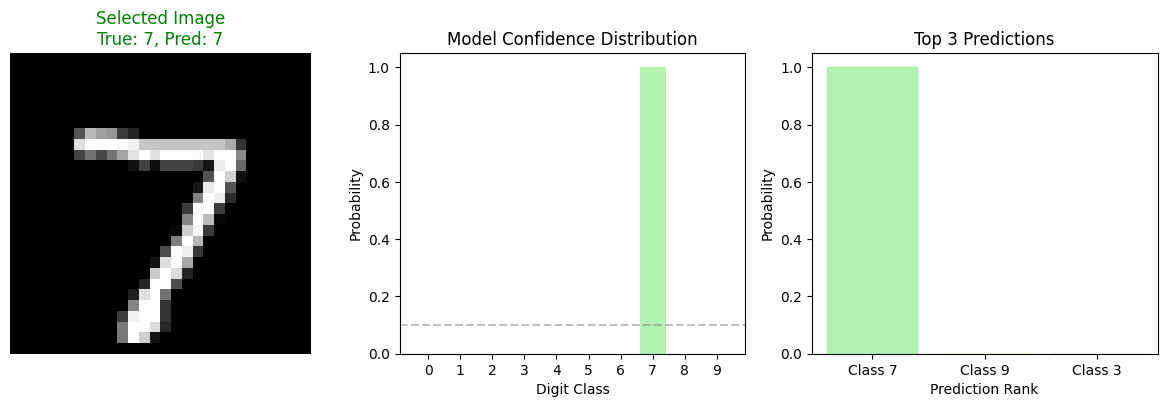

✅ Ready to generate adversarial examples!


In [3]:
# Prepare test data for attack demonstrations
print("📊 Preparing samples for adversarial attacks...")

# Create a single-sample test loader for attack demonstrations
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Find a correctly classified sample for meaningful attack demonstration
print("🔍 Finding a correctly classified sample...")

sample_found = False
sample_count = 0

for sample_image, sample_label in test_loader:
    sample_image = sample_image.to(device)
    sample_label = sample_label.to(device)
    
    # Test if model predicts correctly
    model.eval()
    with torch.no_grad():
        clean_output = model(sample_image)
        clean_pred = torch.argmax(clean_output, dim=1)
        clean_confidence = F.softmax(clean_output, dim=1).max()
    
    sample_count += 1
    
    # Use this sample if correctly predicted or if we've tried many samples
    if clean_pred.item() == sample_label.item() or sample_count >= 20:
        sample_found = True
        break

if clean_pred.item() == sample_label.item():
    print(f"✅ Found correctly classified sample #{sample_count}")
    print(f"📸 Sample: True label = {sample_label.item()}, Predicted = {clean_pred.item()}")
    print(f"🎯 Confidence: {clean_confidence:.4f}")
else:
    print(f"⚠️  Using sample #{sample_count} (may be incorrectly classified)")
    print(f"📸 Sample: True label = {sample_label.item()}, Predicted = {clean_pred.item()}")
    print(f"🎯 Confidence: {clean_confidence:.4f}")

# Visualize the selected sample
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
img_np = sample_image.squeeze().cpu().numpy()
plt.imshow(img_np, cmap='gray')
color = 'green' if clean_pred.item() == sample_label.item() else 'red'
plt.title(f'Selected Image\nTrue: {sample_label.item()}, Pred: {clean_pred.item()}', color=color)
plt.axis('off')

plt.subplot(1, 3, 2)
# Show the prediction probabilities
probs = F.softmax(clean_output, dim=1).squeeze().cpu().numpy()
colors = ['lightcoral' if i != clean_pred.item() else 'lightgreen' for i in range(10)]
plt.bar(range(10), probs, alpha=0.7, color=colors)
plt.xlabel('Digit Class')
plt.ylabel('Probability')
plt.title('Model Confidence Distribution')
plt.xticks(range(10))
plt.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Random (10%)')

plt.subplot(1, 3, 3)
# Show top 3 predictions
top_probs, top_indices = torch.topk(F.softmax(clean_output, dim=1), 3)
top_probs = top_probs.squeeze().cpu().numpy()
top_indices = top_indices.squeeze().cpu().numpy()

bars = plt.bar(range(3), top_probs, alpha=0.7)
bars[0].set_color('lightgreen')  # Highest prediction
bars[1].set_color('orange')      # Second highest
bars[2].set_color('lightcoral')  # Third highest
plt.xlabel('Prediction Rank')
plt.ylabel('Probability')
plt.title('Top 3 Predictions')
plt.xticks(range(3), [f'Class {idx}' for idx in top_indices])

plt.tight_layout()
plt.show()

print("✅ Ready to generate adversarial examples!")


## Part 2: Fast Gradient Sign Method (FGSM)

FGSM is the simplest adversarial attack. It works by:
1. Computing the gradient of the loss with respect to the input
2. Taking the sign of the gradient 
3. Adding a small perturbation in the direction that increases the loss

**Mathematical formula:**
$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x L(\theta, x, y))$$

Where:
- $x$ = original input
- $\epsilon$ = perturbation magnitude (attack strength)
- $L$ = loss function
- $\theta$ = model parameters


🚀 FGSM ATTACK DEMONSTRATION

🎯 Testing epsilon = 0.05
Original prediction: 9 (confidence: 1.0000)
Adversarial prediction: 7 (confidence: 0.9930)
Attack successful: False

🎯 Testing epsilon = 0.1
Original prediction: 9 (confidence: 1.0000)
Adversarial prediction: 7 (confidence: 0.9885)
Attack successful: False

🎯 Testing epsilon = 0.2
Original prediction: 9 (confidence: 1.0000)
Adversarial prediction: 7 (confidence: 0.9678)
Attack successful: False

🎯 Testing epsilon = 0.3
Original prediction: 9 (confidence: 1.0000)
Adversarial prediction: 7 (confidence: 0.9080)
Attack successful: False


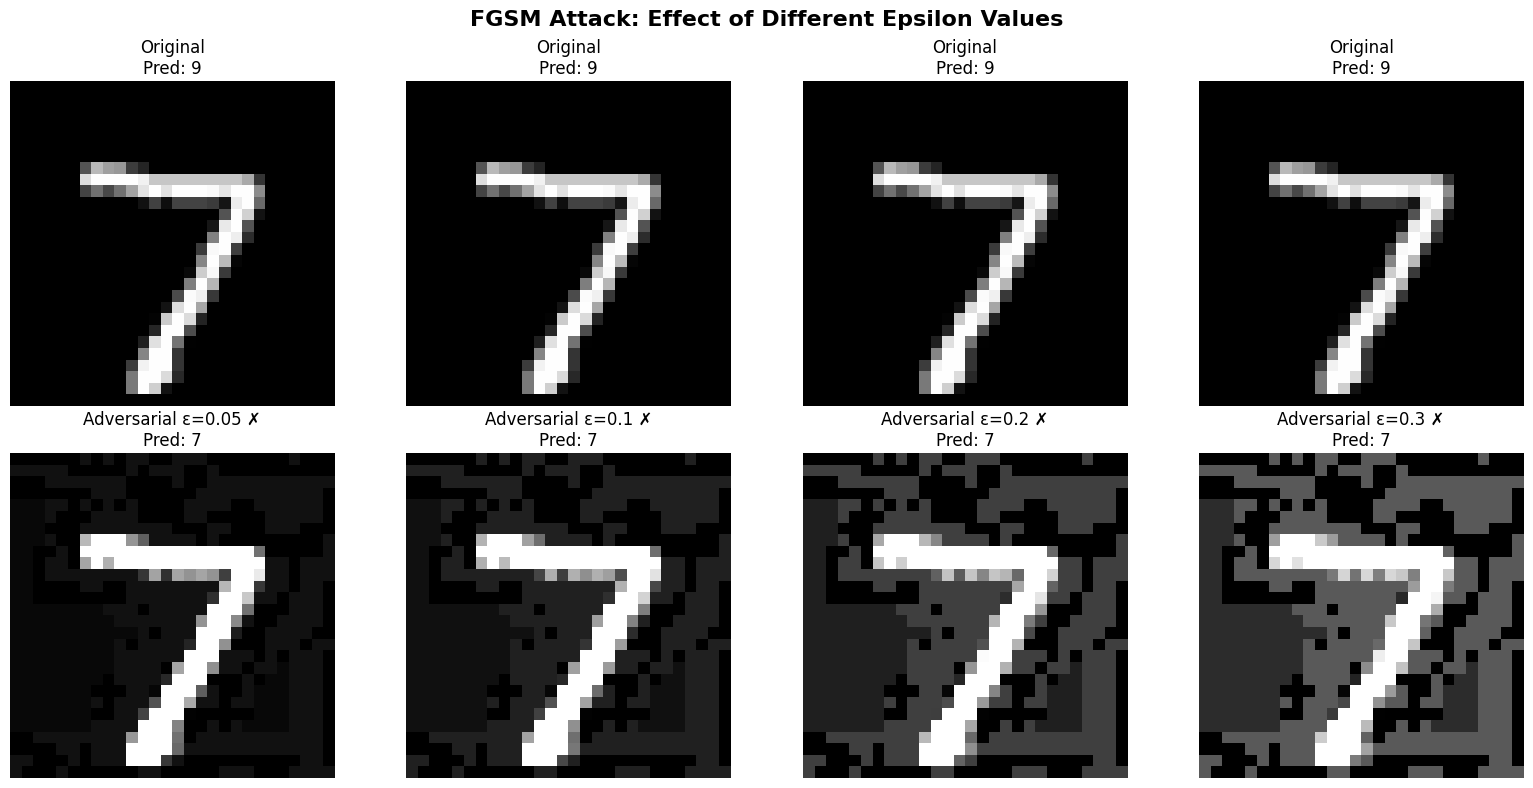


FGSM attacks will (with high probability) not make the model fail, this is expected!
This is because our model is fairly robust

🎉 FGSM attack demonstration complete!


In [11]:
def fgsm_attack(model, image, label, epsilon=0.1):
    """
    Fast Gradient Sign Method (FGSM) attack implementation.
    
    Args:
        model: The target neural network
        image: Input image tensor (requires_grad=True)
        label: True label for the image
        epsilon: Attack strength (perturbation magnitude)
    
    Returns:
        adversarial_image: The crafted adversarial example
        perturbation: The perturbation added to the image
    """
    # Ensure image requires gradients
    image.requires_grad_(True)
    
    # Forward pass
    output = model(image)
    
    # Calculate loss (we want to maximize this)
    loss = F.cross_entropy(output, label)
    
    # Zero gradients and backpropagate
    model.zero_grad()
    loss.backward()
    
    # Get the sign of the gradients
    gradient_sign = image.grad.data.sign()
    
    # Create adversarial example
    perturbation = epsilon * gradient_sign
    adversarial_image = image + perturbation
    
    # Optional: Clamp to valid pixel range
    adversarial_image = torch.clamp(adversarial_image, -1, 1)  # For normalized images
    
    return adversarial_image.detach(), perturbation.detach()

print("🚀 FGSM ATTACK DEMONSTRATION")
print("=" * 50)

# Test different epsilon values
epsilons = [0.05, 0.1, 0.2, 0.3]

fig, axes = plt.subplots(2, len(epsilons), figsize=(16, 8))
fig.suptitle('FGSM Attack: Effect of Different Epsilon Values', fontsize=16, fontweight='bold')

for i, epsilon in enumerate(epsilons):
    print(f"\n🎯 Testing epsilon = {epsilon}")
    
    # Create adversarial example
    adv_image, perturbation = fgsm_attack(model, sample_image.clone(), sample_label, epsilon)
    
    # Test the adversarial example
    model.eval()
    with torch.no_grad():
        adv_output = model(adv_image)
        adv_pred = torch.argmax(adv_output, dim=1)
        adv_confidence = F.softmax(adv_output, dim=1).max()
    
    print(f"Original prediction: {clean_pred.item()} (confidence: {clean_confidence:.4f})")
    print(f"Adversarial prediction: {adv_pred.item()} (confidence: {adv_confidence:.4f})")
    print(f"Attack successful: {adv_pred.item() != sample_label.item()}")
    
    # Plot original and adversarial images
    original_img = sample_image.squeeze().cpu().numpy()
    adv_img = adv_image.squeeze().cpu().numpy()
    perturbation_img = perturbation.squeeze().cpu().numpy()
    
    # Original vs Adversarial
    axes[0, i].imshow(original_img, cmap='gray')
    axes[0, i].set_title(f'Original\nPred: {clean_pred.item()}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(adv_img, cmap='gray')
    success_indicator = "✓" if adv_pred.item() != sample_label.item() else "✗"
    axes[1, i].set_title(f'Adversarial ε={epsilon} {success_indicator}\nPred: {adv_pred.item()}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\nFGSM attacks will (with high probability) not make the model fail, this is expected!")
print("This is because our model is fairly robust")

print("\n🎉 FGSM attack demonstration complete!")


## Part 3: Projected Gradient Descent (PGD) Attack

PGD is a stronger iterative attack that refines the adversarial example over multiple steps:

**Algorithm:**
1. Start with a random perturbation within the $\ell_\infty$ ball
2. For each iteration: Apply FGSM step + project back to constraint set
3. Repeat for multiple iterations

**Mathematical formula:**
$$x_{t+1} = \Pi_{B_\epsilon(x)} \left( x_t + \alpha \cdot \text{sign}(\nabla_x L(\theta, x_t, y)) \right)$$

Where $\Pi_{B_\epsilon(x)}$ projects back to the $\ell_\infty$ ball of radius $\epsilon$ around $x$.


⚡ PGD ATTACK DEMONSTRATION

🔍 Comparing FGSM vs PGD (epsilon = 0.3)

Results:
Original: 7 (confidence: 1.0000)
FGSM:     7 (confidence: 0.9080) - Success: False
PGD:      3 (confidence: 0.8259) - Success: True


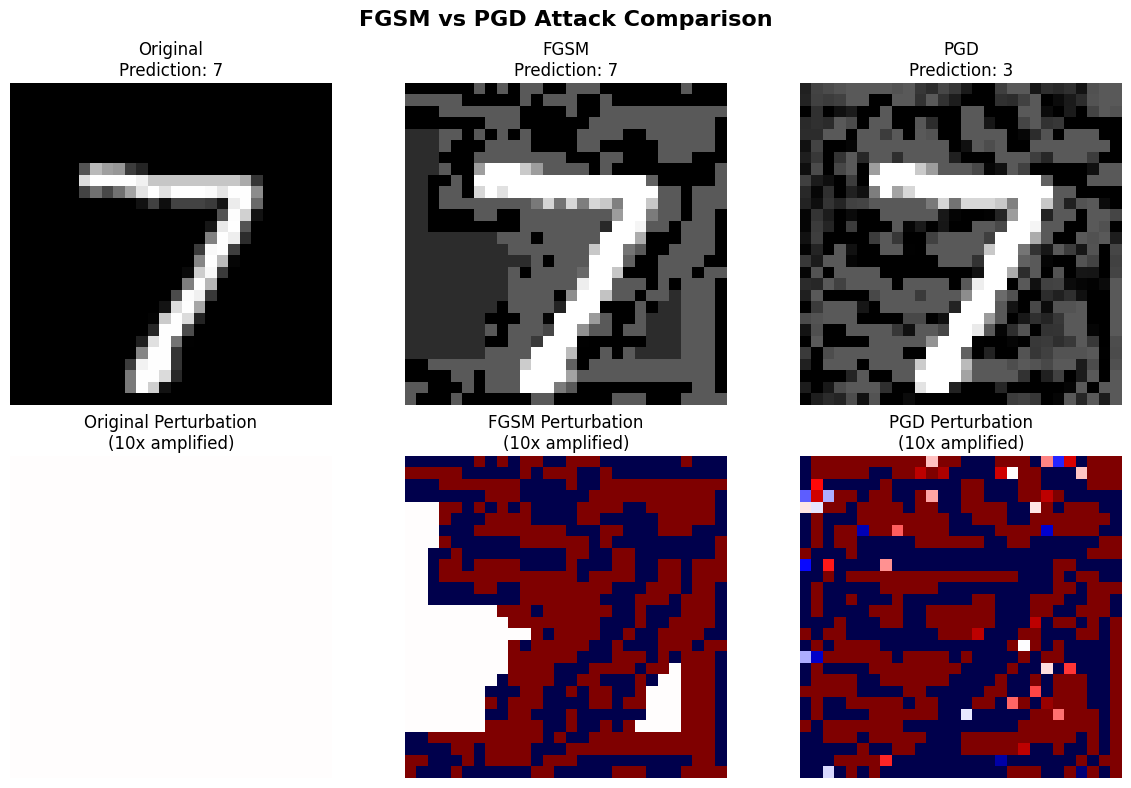


✅ PGD attack demonstration complete!


In [19]:
def pgd_attack(model, image, label, epsilon=0.1, alpha=0.01, num_iter=20):
    """
    Projected Gradient Descent (PGD) attack implementation.
    
    Args:
        model: The target neural network
        image: Input image tensor
        label: True label for the image
        epsilon: Maximum perturbation magnitude (L-infinity norm)
        alpha: Step size for each iteration
        num_iter: Number of PGD iterations
    
    Returns:
        adversarial_image: The crafted adversarial example
        perturbation_history: History of perturbations for visualization
    """
    original_image = image.clone().detach()
    
    # Start with random noise within epsilon ball
    adversarial_image = image.clone().detach()
    adversarial_image += torch.empty_like(adversarial_image).uniform_(-epsilon, epsilon)
    adversarial_image = torch.clamp(adversarial_image, -1, 1)  # Clamp to valid range
    
    perturbation_history = []
    
    for i in range(num_iter):
        adversarial_image.requires_grad_(True)
        
        # Forward pass
        output = model(adversarial_image)
        
        # Calculate loss
        loss = F.cross_entropy(output, label)
        
        # Backpropagate
        model.zero_grad()
        loss.backward()
        
        # Take step in gradient direction
        gradient_sign = adversarial_image.grad.data.sign()
        adversarial_image = adversarial_image.detach() + alpha * gradient_sign
        
        # Project back to epsilon ball around original image
        delta = adversarial_image - original_image
        delta = torch.clamp(delta, -epsilon, epsilon)
        adversarial_image = original_image + delta
        adversarial_image = torch.clamp(adversarial_image, -1, 1)
        
        # Store perturbation for visualization
        perturbation_history.append(delta.clone().detach())
    
    return adversarial_image.detach(), perturbation_history

print("⚡ PGD ATTACK DEMONSTRATION")
print("=" * 50)

# Compare FGSM vs PGD
epsilon = 0.3
print(f"\n🔍 Comparing FGSM vs PGD (epsilon = {epsilon})")

# FGSM attack
fgsm_adv, fgsm_pert = fgsm_attack(model, sample_image.clone(), sample_label, epsilon)

# PGD attack
pgd_adv, pgd_pert_history = pgd_attack(model, sample_image.clone(), sample_label, 
                                       epsilon, alpha=epsilon/20*2.5, num_iter=20)

# Test both adversarial examples
model.eval()
with torch.no_grad():
    fgsm_output = model(fgsm_adv)
    fgsm_pred = torch.argmax(fgsm_output, dim=1)
    fgsm_confidence = F.softmax(fgsm_output, dim=1).max()
    
    pgd_output = model(pgd_adv)
    pgd_pred = torch.argmax(pgd_output, dim=1)
    pgd_confidence = F.softmax(pgd_output, dim=1).max()

print(f"\nResults:")
print(f"Original: {sample_label.item()} (confidence: {clean_confidence:.4f})")
print(f"FGSM:     {fgsm_pred.item()} (confidence: {fgsm_confidence:.4f}) - Success: {fgsm_pred.item() != sample_label.item()}")
print(f"PGD:      {pgd_pred.item()} (confidence: {pgd_confidence:.4f}) - Success: {pgd_pred.item() != sample_label.item()}")

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('FGSM vs PGD Attack Comparison', fontsize=16, fontweight='bold')

# Images
images = [sample_image, fgsm_adv, pgd_adv]
titles = ['Original', 'FGSM', 'PGD']
preds = [sample_label.item(), fgsm_pred.item(), pgd_pred.item()]

for i, (img, title, pred) in enumerate(zip(images, titles, preds)):
    axes[0, i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'{title}\nPrediction: {pred}')
    axes[0, i].axis('off')

# Perturbations (amplified for visibility)
perturbations = [torch.zeros_like(sample_image), fgsm_pert, pgd_pert_history[-1]]
for i, pert in enumerate(perturbations):
    # Amplify perturbation for visualization
    pert_vis = pert * 10 + 0.5  # Scale and shift for visibility
    axes[1, i].imshow(pert_vis.squeeze().cpu().numpy(), cmap='seismic', vmin=0, vmax=1)
    axes[1, i].set_title(f'{titles[i]} Perturbation\n(10x amplified)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ PGD attack demonstration complete!")


## Part 4: Evaluate attacks

Now let's evaluate the success rate of our adversarial attacks.

📊 EVALUATING ATTACK SUCCESS RATES

Testing epsilon = 0.05
Testing fgsm_attack with epsilon=0.05 on 50 samples...


Attacking: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 323.10it/s]


Attack Success Rate: 0/50 = 0.00%
Testing pgd_attack with epsilon=0.05 on 50 samples...


Attacking: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.51it/s]


Attack Success Rate: 0/50 = 0.00%

Testing epsilon = 0.1
Testing fgsm_attack with epsilon=0.1 on 50 samples...


Attacking: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 377.87it/s]


Attack Success Rate: 0/50 = 0.00%
Testing pgd_attack with epsilon=0.1 on 50 samples...


Attacking: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.60it/s]


Attack Success Rate: 1/50 = 2.00%

Testing epsilon = 0.15
Testing fgsm_attack with epsilon=0.15 on 50 samples...


Attacking: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 386.67it/s]


Attack Success Rate: 1/50 = 2.00%
Testing pgd_attack with epsilon=0.15 on 50 samples...


Attacking: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.41it/s]


Attack Success Rate: 3/50 = 6.00%

Testing epsilon = 0.2
Testing fgsm_attack with epsilon=0.2 on 50 samples...


Attacking: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 380.51it/s]


Attack Success Rate: 2/50 = 4.00%
Testing pgd_attack with epsilon=0.2 on 50 samples...


Attacking: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.53it/s]


Attack Success Rate: 11/50 = 22.00%


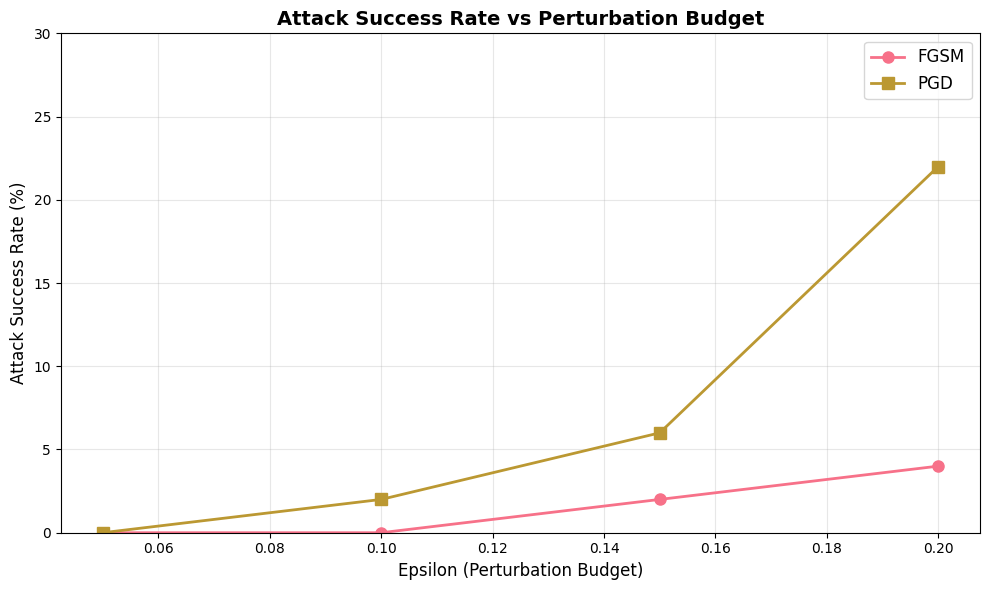


🎯 Key Observations:
- PGD generally achieves higher success rates than FGSM
- Higher epsilon values lead to more successful attacks
- Both attacks can fool the model with small perturbations

✅ Attack evaluation complete!


In [25]:
# 📊 SYSTEMATIC ATTACK EVALUATION
print("📊 EVALUATING ATTACK SUCCESS RATES")
print("=" * 50)

def evaluate_attack_success(model, test_loader, attack_function, epsilon, num_samples=100):
    """Evaluate attack success rate on multiple samples."""
    model.eval()
    successes = 0
    total = 0
    
    print(f"Testing {attack_function.__name__} with epsilon={epsilon} on {num_samples} samples...")
    
    with tqdm(total=num_samples, desc="Attacking") as pbar:
        for i, (image, label) in enumerate(test_loader):
            if total >= num_samples:
                break
                
            image, label = image.to(device), label.to(device)
            
            # Get clean prediction
            with torch.no_grad():
                clean_output = model(image)
                clean_pred = torch.argmax(clean_output, dim=1)
            
            # Skip if model doesn't classify correctly originally
            if clean_pred.item() != label.item():
                continue
            
            # Generate adversarial example
            if attack_function.__name__ == 'fgsm_attack':
                adv_image, _ = attack_function(model, image, label, epsilon)
            else:  # PGD
                adv_image, _ = attack_function(model, image, label, epsilon, alpha=epsilon/10, num_iter=20)
            
            # Test adversarial example
            with torch.no_grad():
                adv_output = model(adv_image)
                adv_pred = torch.argmax(adv_output, dim=1)
            
            # Count success (misclassification)
            if adv_pred.item() != label.item():
                successes += 1
            
            total += 1
            pbar.update(1)
    
    success_rate = successes / total * 100 if total > 0 else 0
    print(f"Attack Success Rate: {successes}/{total} = {success_rate:.2f}%")
    return success_rate

# Test different epsilons for both attacks
epsilons_test = [0.05, 0.1, 0.15, 0.2]
fgsm_results = []
pgd_results = []

for eps in epsilons_test:
    print(f"\n{'='*30}")
    print(f"Testing epsilon = {eps}")
    print(f"{'='*30}")
    
    fgsm_rate = evaluate_attack_success(model, test_loader, fgsm_attack, eps, num_samples=50)
    pgd_rate = evaluate_attack_success(model, test_loader, pgd_attack, eps, num_samples=50)
    
    fgsm_results.append(fgsm_rate)
    pgd_results.append(pgd_rate)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(epsilons_test, fgsm_results, 'o-', label='FGSM', linewidth=2, markersize=8)
plt.plot(epsilons_test, pgd_results, 's-', label='PGD', linewidth=2, markersize=8)
plt.xlabel('Epsilon (Perturbation Budget)', fontsize=12)
plt.ylabel('Attack Success Rate (%)', fontsize=12)
plt.title('Attack Success Rate vs Perturbation Budget', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 30)

plt.tight_layout()
plt.show()

print("\n🎯 Key Observations:")
print("- PGD generally achieves higher success rates than FGSM")
print("- Higher epsilon values lead to more successful attacks")
print("- Both attacks can fool the model with small perturbations")
print("\n✅ Attack evaluation complete!")


## 🎉 Recitation Complete!

**Congratulations!** You have successfully:

Ready to dive deeper into adversarial machine learning? Complete Assignment 3! 🚀
